# Comparativo: NGBoost vs LightGBM para Classificação Binária em Crédito
Este notebook compara os modelos **LightGBM** e **NGBoost** usando o dataset de inadimplência de cartões de crédito.
Ao final, apresentamos um formato de decisão (DECIS) com base em métricas de performance.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregar dados
df = pd.read_csv('UCI_Credit_Card.csv')
y = df['default.payment.next.month']
X = df.drop(columns=['ID', 'default.payment.next.month'])

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [3]:
%%time
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]
roc_lgbm = roc_auc_score(y_test, y_proba_lgbm)
print('ROC AUC - LightGBM:', roc_lgbm)

[LightGBM] [Info] Number of positive: 4645, number of negative: 16355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3262
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221190 -> initscore=-1.258742
[LightGBM] [Info] Start training from score -1.258742
ROC AUC - LightGBM: 0.7766093805345627
CPU times: total: 2.02 s
Wall time: 675 ms


In [4]:
%%time
ngb = NGBClassifier(Dist=Bernoulli, verbose=False, random_state=42)
ngb.fit(X_train, y_train)
y_proba_ngb = ngb.predict_proba(X_test)[:, 1]
roc_ngb = roc_auc_score(y_test, y_proba_ngb)
print('ROC AUC - NGBoost:', roc_ngb)

ROC AUC - NGBoost: 0.7771036506912008
CPU times: total: 1min 57s
Wall time: 1min 58s


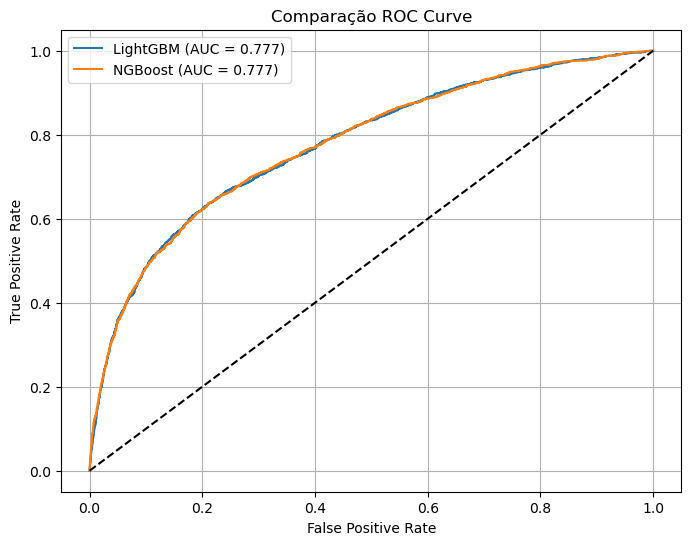

In [5]:
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)
fpr_ngb, tpr_ngb, _ = roc_curve(y_test, y_proba_ngb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {roc_lgbm:.3f})')
plt.plot(fpr_ngb, tpr_ngb, label=f'NGBoost (AUC = {roc_ngb:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparação ROC Curve')
plt.legend()
plt.grid()
plt.show()

## Formato DECIS (Decisão com Interpretação Simples)
A seguir, geramos uma recomendação para escolha do modelo com base em desempenho e utilidade prática.

In [6]:
print('DECIS:')
if roc_lgbm > roc_ngb:
    print('- LightGBM apresenta melhor desempenho em AUC.')
    print('- Recomendado quando a prioridade for performance bruta.')
else:
    print('- NGBoost apresenta desempenho competitivo com vantagem de modelar incertezas.')
    print('- Recomendado para aplicações onde interpretar incerteza seja crucial.')

DECIS:
- NGBoost apresenta desempenho competitivo com vantagem de modelar incertezas.
- Recomendado para aplicações onde interpretar incerteza seja crucial.


In [7]:
def gerar_tabela_decisao(y_true, y_proba, n_bins=10):
    df = pd.DataFrame({'y_true': y_true, 'score': y_proba})
    df['faixa'] = pd.qcut(df['score'], q=n_bins, duplicates='drop', labels=False)
    df['faixa'] = (n_bins - 1) - df['faixa']  # Faixa 0 = maiores scores

    resumo = df.groupby('faixa').apply(lambda g: pd.Series({
        'quantidade': len(g),
        'qtd_bons': (g['y_true'] == 0).sum(),
        'qtd_maus': (g['y_true'] == 1).sum()
    })).reset_index()

    total_bons = (df['y_true'] == 0).sum()
    total_maus = (df['y_true'] == 1).sum()

    resumo = resumo.sort_values('faixa')
    resumo['acumulado'] = resumo['quantidade'].cumsum()
    resumo['acumulado_maus'] = resumo['qtd_maus'].cumsum()
    resumo['acumulado_pct'] = resumo['acumulado'] / resumo['quantidade'].sum()
    resumo['acumulado_maus_pct'] = resumo['acumulado_maus'] / total_maus
    resumo['acumulado_bons_pct'] = resumo['qtd_bons'].cumsum() / total_bons
    resumo['ks'] = np.abs(resumo['acumulado_maus_pct'] - resumo['acumulado_bons_pct'])

    resumo['acum_pop'] = resumo['quantidade'].iloc[::-1].cumsum()
    resumo['acum_bad'] = resumo['qtd_maus'].iloc[::-1].cumsum()
    resumo['%bad'] = resumo['qtd_maus']/resumo['quantidade']
    resumo['%acum_bad'] = resumo['acum_bad']/resumo['acum_pop']
    resumo['%acum_pop'] = resumo['acum_pop']/resumo['quantidade'].sum()
    resumo = resumo[['faixa', '%bad', 'ks', '%acum_bad',  '%acum_pop']]
    resumo.columns = ['FAIXA','%BAD', 'KS', '%ACUM_BAD', '%ACUM_POP']
    for col in ['%BAD', 'KS', '%ACUM_BAD', '%ACUM_POP']:
        resumo[col] = round((resumo[col]*100),2)
    return resumo

# Tabelas no conjunto de teste
tabela_lgbm = gerar_tabela_decisao(y_test, y_proba_lgbm)
tabela_ngb = gerar_tabela_decisao(y_test, y_proba_ngb)

print("\nTabela de Decisão - LightGBM")
print(tabela_lgbm)





Tabela de Decisão - LightGBM
   FAIXA   %BAD     KS  %ACUM_BAD  %ACUM_POP
0      0  69.22  27.34      22.12      100.0
1      1  43.44  39.72      16.89       90.0
2      2  26.67  42.35      13.57       80.0
3      3  17.44  39.64      11.70       70.0
4      4  17.11  36.73      10.74       60.0
5      5  14.00  32.01       9.47       50.0
6      6  12.78  26.59       8.33       40.0
7      7   9.11  19.04       6.85       30.0
8      8   7.00  10.26       5.72       20.0
9      9   4.44   0.00       4.44       10.0


C:\Users\Eduardo\AppData\Local\Temp\ipykernel_6280\1219763930.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumo = df.groupby('faixa').apply(lambda g: pd.Series({
C:\Users\Eduardo\AppData\Local\Temp\ipykernel_6280\1219763930.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumo = df.groupby('faixa').apply(lambda g: pd.Series({


In [8]:
tabela_lgbm

,FAIXA,%BAD,KS,%ACUM_BAD,%ACUM_POP
0,0,69.22,27.34,22.12,100.0
1,1,43.44,39.72,16.89,90.0
2,2,26.67,42.35,13.57,80.0
3,3,17.44,39.64,11.70,70.0
4,4,17.11,36.73,10.74,60.0
5,5,14.00,32.01,9.47,50.0
6,6,12.78,26.59,8.33,40.0
7,7,9.11,19.04,6.85,30.0
8,8,7.00,10.26,5.72,20.0
9,9,4.44,0.00,4.44,10.0


In [9]:
tabela_ngb

,FAIXA,%BAD,KS,%ACUM_BAD,%ACUM_POP
0,0,68.67,27.02,22.12,100.0
1,1,43.33,39.33,16.95,90.0
2,2,27.00,42.16,13.65,80.0
3,3,18.67,40.15,11.75,70.0
4,4,16.11,36.66,10.59,60.0
5,5,15.22,32.66,9.49,50.0
6,6,11.11,26.27,8.06,40.0
7,7,10.44,19.49,7.04,30.0
8,8,5.44,9.81,5.33,20.0
9,9,5.22,0.00,5.22,10.0


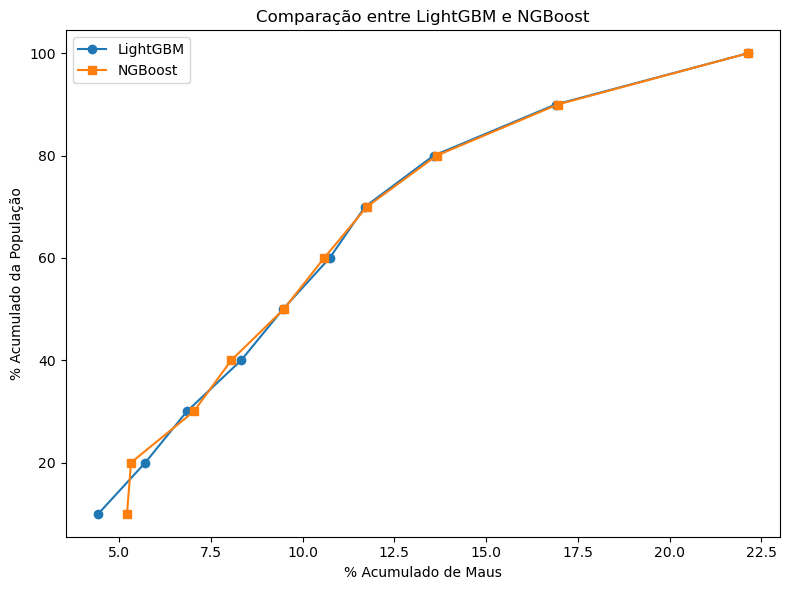

In [11]:
plt.style.use('default')

plt.figure(figsize=(8, 6))

# Plot LGBM
plt.plot(tabela_lgbm['%ACUM_BAD'], tabela_lgbm['%ACUM_POP'], marker='o', label='LightGBM')

# Plot NGBoost
plt.plot(tabela_ngb['%ACUM_BAD'], tabela_ngb['%ACUM_POP'], marker='s', label='NGBoost')

# Eixos
plt.xlabel('% Acumulado de Maus')
plt.ylabel('% Acumulado da População')
plt.title('Comparação entre LightGBM e NGBoost')
plt.legend()
plt.tight_layout()
plt.show()


## CONSIDERAÇÕES

| Critério                     | LightGBM                           | NGBoost                            |
| ---------------------------- | ---------------------------------- | ---------------------------------- |
| **Tempo de Treinamento (s)** |                                    |                                    |
| **Tempo de Predição (s)**    |                                    |                                    |
| **AUC ROC (val/teste)**      |                                    |                                    |
| **KS (val/teste)**           |                                    |                                    |
| **%BAD faixa 1**             |                                    |                                    |
| **%ACUM\_BAD faixa 1**       |                                    |                                    |
| **%ACUM\_POP faixa 1**       |                                    |                                    |
| **Melhor Faixa KS**          |                                    |                                    |
| **Execução em produção**     | ✅ Rápido, leve                     | ⚠️ Mais lento, avaliar viabilidade |
| **Interpretação**            | ✅ SHAP, ganho, árvore              | ✅ Distribuição + incerteza         |
| **Robustez ao ruído**        | ⚠️ Boa, mas sensível a overfitting | ✅ Mais robusto a incertezas        |
| **Facilidade de uso**        | ✅ Amplo suporte, bem documentado   | ⚠️ Requer conhecimento teórico     |
| **Ponto Forte**              |                                    |                                    |
| **Ponto Fraco**              |                                    |                                    |
| **Observações Gerais**       |                                    |                                    |
